# Content

1. [Description](#Description)
2. [Import](#Import)
3. [Paramethers](#Paramethers)
4. [Data preparation](#Data-preparation)
5. [Modeling](#Modeling)
6. [Training](#Training)
7. [Evaluating](#Evaluating)
8. [Save model](#Save-model)

### Description

It is a code from the tutorial of [pyimagesearch](https://www.pyimagesearch.com/). Name of tutorail: 

- **COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning** [LINK](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/)

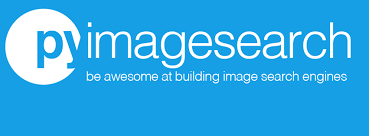

### Import

In [2]:
import os

In [4]:
import argparse
from imutils import paths

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Paramethers

In [23]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [11]:
DATA_PATH = "dataset"

### Data preparation

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

imagePaths = list(paths.list_images(DATA_PATH))
data = []
labels = []

In [13]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [14]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [16]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(
    data, 
    labels, 
    test_size=0.20, 
    stratify=labels, 
    random_state=42
)

In [17]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

### Modeling

In [18]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

/Users/oleksandrkosovan/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 3s 0us/step


In [19]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [25]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [27]:
# model.summary()

### Training

In [28]:
# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO] training head...
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 139s 4s/step - loss: 0.6867 - accuracy: 0.6367 - val_loss: 0.3510 - val_accuracy: 0.8906
Epoch 2/20
34/34 [==============================] - 121s 4s/step - loss: 0.4376 - accuracy: 0.8052 - val_loss: 0.2101 - val_accuracy: 0.9727
Epoch 3/20
34/34 [==============================] - 109s 3s/step - loss: 0.3103 - accuracy: 0.8680 - val_loss: 0.1337 - val_accuracy: 0.9844
Epoch 4/20
34/34 [==============================] - 135s 4s/step - loss: 0.2418 - accuracy: 0.9053 - val_loss: 0.0959 - val_accuracy: 0.9844
Epoch 5/20
34/34 [==============================] - 109s 3s/step - loss: 0.2110 - accuracy: 0.9242 - val_loss: 0.0691 - val_accuracy: 0.9883
Epoch 6/20
34/34 [==============================] - 110s 3s/step - loss: 0.1924 - accuracy: 0.9251 - val_loss: 0.0669 - val_accuracy: 0.9883
Epoch 7/20
34/34 [==============================] - 109s 3s/step - loss: 0.1563 - accu

### Evaluating

In [30]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

In [31]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [32]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



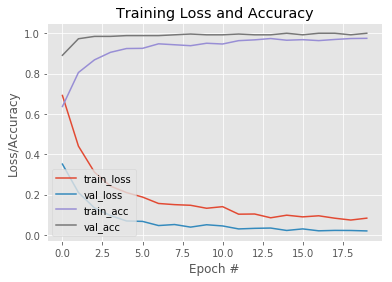

In [34]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Save model

In [33]:
# serialize the model to disk
model.save("models/model.h5", save_format="h5")